In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [45]:
import yfinance as yf

# Choose stock ticker and date range
TICKER = "AAPL"  # change to any ticker
START_DATE = "2018-01-01"
END_DATE = "2024-12-31"
# Download data
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
# Reset index for Date column
data.reset_index(inplace=True)
# Save CSV for later use (optional)
data.to_csv("stock_data.csv", index=False)
print("Downloaded data for:", TICKER)
data.head()

/tmp/ipython-input-1318709905.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Downloaded data for: AAPL


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2018-01-02,40.426823,40.436212,39.722768,39.933986,102223600
1,2018-01-03,40.419788,40.964259,40.356426,40.490195,118071600
2,2018-01-04,40.607536,40.710798,40.384586,40.492539,89738400
3,2018-01-05,41.069851,41.156683,40.612216,40.703743,94640000
4,2018-01-08,40.917320,41.213022,40.818749,40.917320,82271200


In [11]:
data.describe()

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
count,1760,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,2021-06-30 22:10:21.818181632,122.034342,123.244488,120.685784,121.911134,1.001761e+08
min,2018-01-02 00:00:00,33.870838,34.711713,33.825578,34.297229,2.323470e+07
25%,2019-10-01 18:00:00,54.191198,54.893800,53.815230,54.384607,6.312485e+07
50%,2021-06-30 12:00:00,131.693497,133.129900,130.327026,132.042877,8.674660e+07
75%,2023-03-30 06:00:00,169.007172,170.557932,167.550540,168.782719,1.214590e+08
max,2024-12-30 00:00:00,258.396667,259.474086,257.010028,257.568678,4.265100e+08
std,NaN,59.181333,59.650758,58.616838,59.106719,5.520982e+07


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1760 non-null   datetime64[ns]
 1   (Close, AAPL)   1760 non-null   float64       
 2   (High, AAPL)    1760 non-null   float64       
 3   (Low, AAPL)     1760 non-null   float64       
 4   (Open, AAPL)    1760 non-null   float64       
 5   (Volume, AAPL)  1760 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.6 KB


In [13]:
# Change this to your CSV path
CSV_PATH = "/content/stock_data.csv"
DATE_COL = "Date"
TARGET_COL = "Close"
TEST_SIZE = 0.2

# Load data
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df.sort_values(DATE_COL, inplace=True)
df = df[[DATE_COL, TARGET_COL]].dropna().reset_index(drop=True)
df.columns = ["ds", "y"]  # Prophet naming

df.head()


,ds,y
0,2018-01-02,40.426822662353516
1,2018-01-03,40.4197883605957
2,2018-01-04,40.60753631591797
3,2018-01-05,41.06985092163086
4,2018-01-08,40.917320251464844


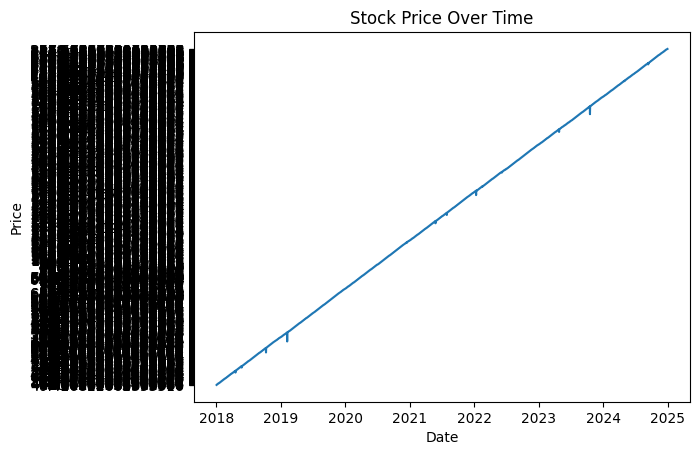

Date range: 2018-01-02 00:00:00 -> 2024-12-30 00:00:00
count                  1760
unique                 1741
top       53.85439682006836
freq                      2
Name: y, dtype: object


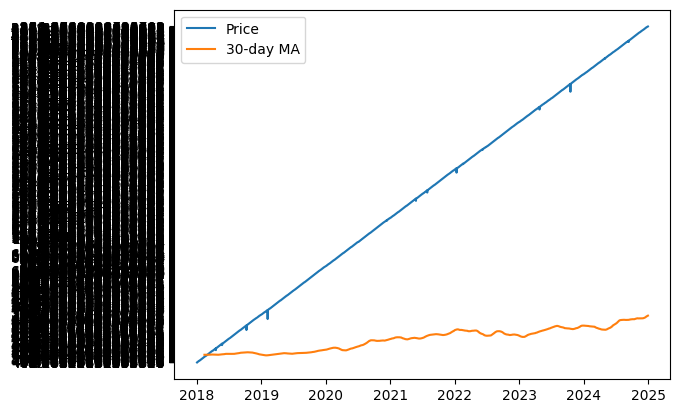

In [14]:
plt.plot(df['ds'], df['y'])
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

print("Date range:", df['ds'].min(), "->", df['ds'].max())
print(df['y'].describe())

# Rolling mean
df['rolling_30'] = df['y'].rolling(window=30).mean()
plt.plot(df['ds'], df['y'], label='Price')
plt.plot(df['ds'], df['rolling_30'], label='30-day MA')
plt.legend()
plt.show()


In [15]:
def adf_test(series, signif=0.05):
    res = adfuller(series.dropna())
    print("ADF stat:", res[0])
    print("p-value:", res[1])
    if res[1] <= signif:
        print("Series is stationary")
    else:
        print("Series is NOT stationary")

adf_test(df['y'])


ADF stat: 0.08300210661095311
p-value: 0.9648812233955324
Series is NOT stationary


In [16]:
n = len(df)
train_n = int((1 - TEST_SIZE) * n)
train_df = df.iloc[:train_n].copy().reset_index(drop=True)
test_df  = df.iloc[train_n:].copy().reset_index(drop=True)

print("Train:", train_df['ds'].min(), "->", train_df['ds'].max())
print("Test :", test_df['ds'].min(), "->", test_df['ds'].max())


Train: 2018-01-02 00:00:00 -> 2023-08-07 00:00:00
Test : 2023-08-08 00:00:00 -> 2024-12-30 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeuks0x4q/1oakrqir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeuks0x4q/6oblar69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4034', 'data', 'file=/tmp/tmpeuks0x4q/1oakrqir.json', 'init=/tmp/tmpeuks0x4q/6oblar69.json', 'output', 'file=/tmp/tmpeuks0x4q/prophet_model7231xw0l/prophet_model-20250809172228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


⚠ Prophet evaluation skipped due to invalid forecast values.


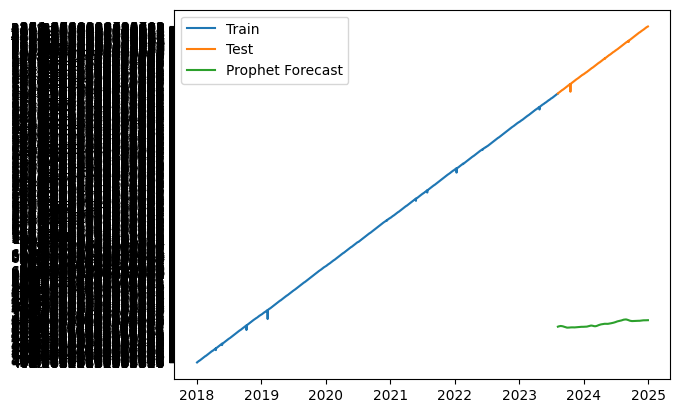

In [21]:
from prophet import Prophet

# --- Ensure ds is datetime & y is numeric ---
prophet_df = train_df.copy()
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce')
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')

# Drop rows with NaNs in ds or y
prophet_df = prophet_df.dropna(subset=['ds', 'y'])

# Check if enough data for Prophet
if len(prophet_df) < 2:
    print("⚠ Not enough data for Prophet. Skipping...")
    prophet_forecast = [np.nan] * len(test_df)
else:
    # Fit Prophet
    model = Prophet()
    model.fit(prophet_df)

    # Create future DataFrame
    future = pd.DataFrame({'ds': test_df['ds']})
    future['ds'] = pd.to_datetime(future['ds'], errors='coerce')

    # Forecast
    forecast = model.predict(future)
    prophet_forecast = forecast['yhat'].values

# --- Evaluation ---
try:
    prophet_rmse = mean_squared_error(test_df['y'], prophet_forecast, squared=False)
    prophet_mape = mean_absolute_percentage_error(test_df['y'], prophet_forecast)
    print("Prophet RMSE:", prophet_rmse, "MAPE:", prophet_mape)
except:
    print("⚠ Prophet evaluation skipped due to invalid forecast values.")

# --- Plot ---
plt.plot(train_df['ds'], train_df['y'], label='Train')
plt.plot(test_df['ds'], test_df['y'], label='Test')
if np.isfinite(prophet_forecast).any():
    plt.plot(test_df['ds'], prophet_forecast, label='Prophet Forecast')
plt.legend()
plt.show()


In [24]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df['y'].values.reshape(-1,1))
test_scaled = scaler.transform(test_df['y'].values.reshape(-1,1))

def create_sequences(series, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(series)):
        X.append(series[i-seq_len:i, 0])
        y.append(series[i, 0])
    return np.array(X).reshape(-1, seq_len, 1), np.array(y)

SEQ_LEN = 60
X_train, y_train_seq = create_sequences(train_scaled, seq_len=SEQ_LEN)
concat = np.concatenate([train_scaled[-SEQ_LEN:], test_scaled], axis=0)
X_test, y_test_seq = create_sequences(concat, seq_len=SEQ_LEN)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (1348, 60, 1) X_test: (352, 60, 1)


In [55]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN,1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train, y_train_seq, epochs=30, batch_size=32,
                    validation_split=0.1, shuffle=False)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0046 - val_loss: 0.0291
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0118 - val_loss: 0.0105
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0089 - val_loss: 0.0113
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0044 - val_loss: 0.0168
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0068 - val_loss: 0.0190
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0032 - val_loss: 0.0160
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0015 - val_loss: 0.0233
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0020 - val_loss: 0.0321
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0029 - val_loss: 0.0288
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0049 - val_loss: 0.0188
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0079 - val_loss: 0.0167
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0

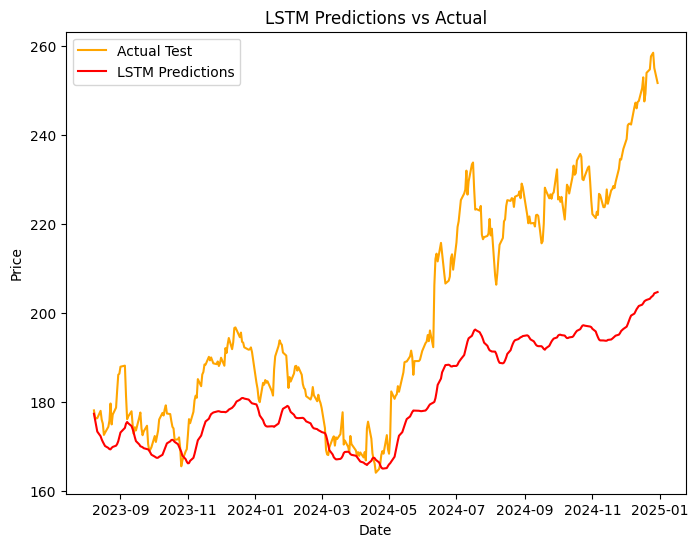

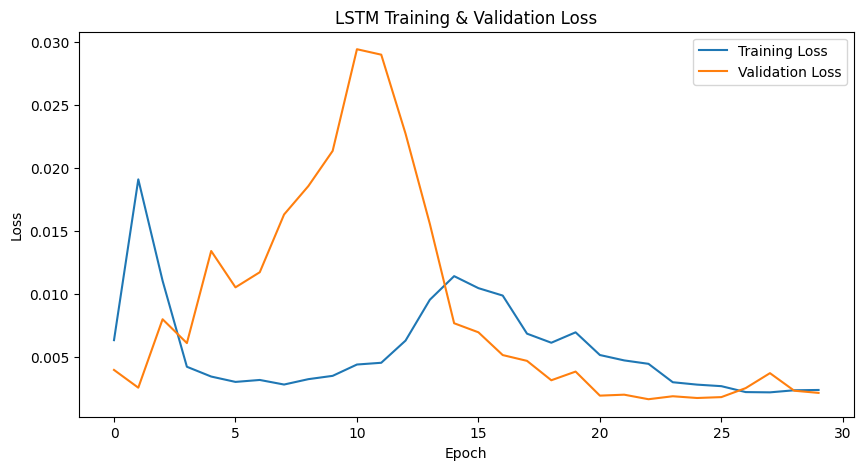

In [52]:
# --- LSTM: Actual vs Predicted ---
plt.figure(figsize=(8,6))
plt.plot(test_df['ds'][:len(lstm_pred)], y_test_true, label='Actual Test', color='orange')
plt.plot(test_df['ds'][:len(lstm_pred)], lstm_pred, label='LSTM Predictions', color='red')
plt.title("LSTM Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# --- LSTM: Loss Curve ---
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Ensure both are numpy arrays
y_test_true = np.array(test_df['y'].values[:len(lstm_pred)], dtype=float)
lstm_pred = np.array(lstm_pred, dtype=float)

# Compute RMSE manually
lstm_rmse = np.sqrt(mean_squared_error(y_test_true, lstm_pred))
lstm_mape = mean_absolute_percentage_error(y_test_true, lstm_pred)

print("LSTM RMSE:", lstm_rmse, "MAPE:", lstm_mape)


LSTM RMSE: 22.48812345047802 MAPE: 0.08253721424974515


In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Ensure everything is numpy float arrays ---
y_test_true = np.array(test_df['y'].values, dtype=float)
arima_forecast = np.array(arima_forecast, dtype=float)
prophet_forecast = np.array(prophet_forecast, dtype=float)
lstm_pred = np.array(lstm_pred, dtype=float)

# --- ARIMA metrics ---
arima_rmse = np.sqrt(mean_squared_error(y_test_true, arima_forecast))
arima_mape = mean_absolute_percentage_error(y_test_true, arima_forecast)

# --- Prophet metrics ---
prophet_rmse = np.sqrt(mean_squared_error(y_test_true, prophet_forecast))
prophet_mape = mean_absolute_percentage_error(y_test_true, prophet_forecast)

# --- LSTM metrics ---
lstm_rmse = np.sqrt(mean_squared_error(y_test_true[:len(lstm_pred)], lstm_pred))
lstm_mape = mean_absolute_percentage_error(y_test_true[:len(lstm_pred)], lstm_pred)

# --- Print results ---
print("ARIMA  - RMSE:", arima_rmse, "MAPE:", arima_mape)
print("Prophet - RMSE:", prophet_rmse, "MAPE:", prophet_mape)
print("LSTM   - RMSE:", lstm_rmse, "MAPE:", lstm_mape)


ARIMA  - RMSE: 17.848958197252276 MAPE: 0.07141878528981296
Prophet - RMSE: 14.41586741621371 MAPE: 0.05843104842677931
LSTM   - RMSE: 22.48812345047802 MAPE: 0.08253721424974515


In [32]:
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM"],
    "RMSE": [arima_rmse, prophet_rmse, lstm_rmse],
    "MAPE": [arima_mape, prophet_mape, lstm_mape]
})
results


,Model,RMSE,MAPE
0,ARIMA,17.848958,0.071419
1,Prophet,14.415867,0.058431
2,LSTM,22.488123,0.082537


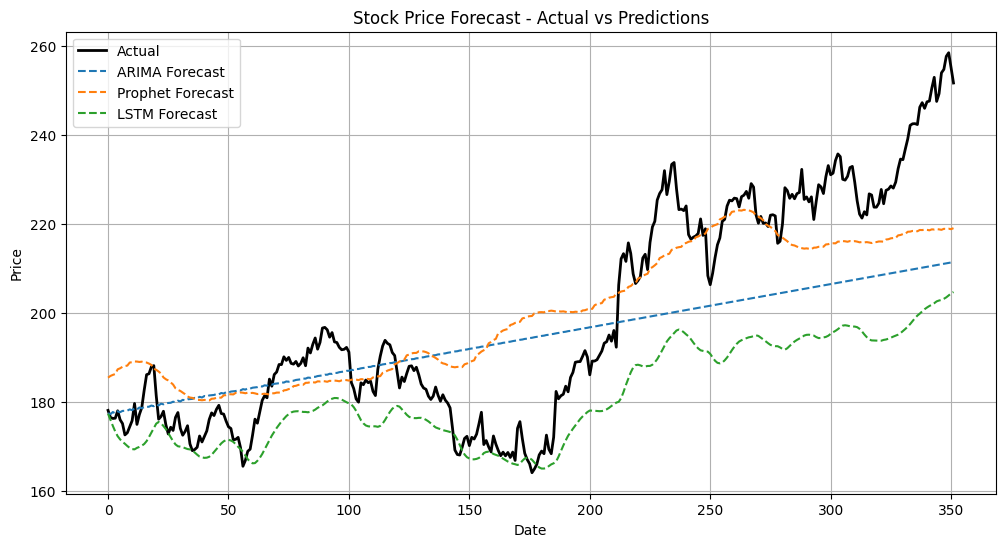

In [48]:
# Line plot: Actual vs Predictions
plt.figure(figsize=(12,6))
plt.plot(test_df.index, y_test_true, label="Actual", color="black", linewidth=2)
plt.plot(test_df.index, arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(test_df.index, prophet_forecast, label="Prophet Forecast", linestyle="--")
plt.plot(test_df.index[:len(lstm_pred)], lstm_pred, label="LSTM Forecast", linestyle="--")
plt.title("Stock Price Forecast - Actual vs Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


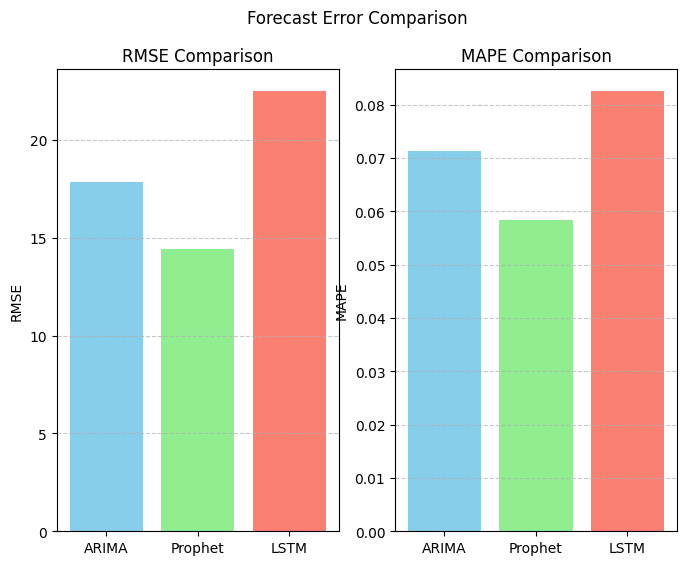

In [42]:
# Bar charts: RMSE & MAPE
fig, axes = plt.subplots(1, 2, figsize=(8,))

# RMSE
axes[0].bar(results_df['Model'], results_df['RMSE'], color=['skyblue','lightgreen','salmon'])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# MAPE
axes[1].bar(results_df['Model'], results_df['MAPE'], color=['skyblue','lightgreen','salmon'])
axes[1].set_title("MAPE Comparison")
axes[1].set_ylabel("MAPE")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Forecast Error Comparison")
plt.show()


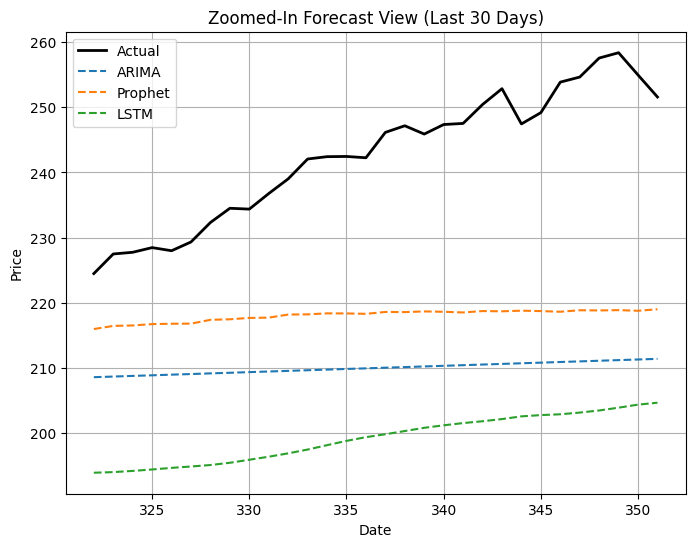

In [40]:
# Zoomed-In Forecast View (Last 30 Days)
plt.figure(figsize=(8,6))
plt.plot(test_df.index[-30:], y_test_true[-30:], label="Actual", color="black", linewidth=2)
plt.plot(test_df.index[-30:], arima_forecast[-30:], label="ARIMA", linestyle="--")
plt.plot(test_df.index[-30:], prophet_forecast[-30:], label="Prophet", linestyle="--")
plt.plot(test_df.index[:len(lstm_pred)][-30:], lstm_pred[-30:], label="LSTM", linestyle="--")
plt.title("Zoomed-In Forecast View (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


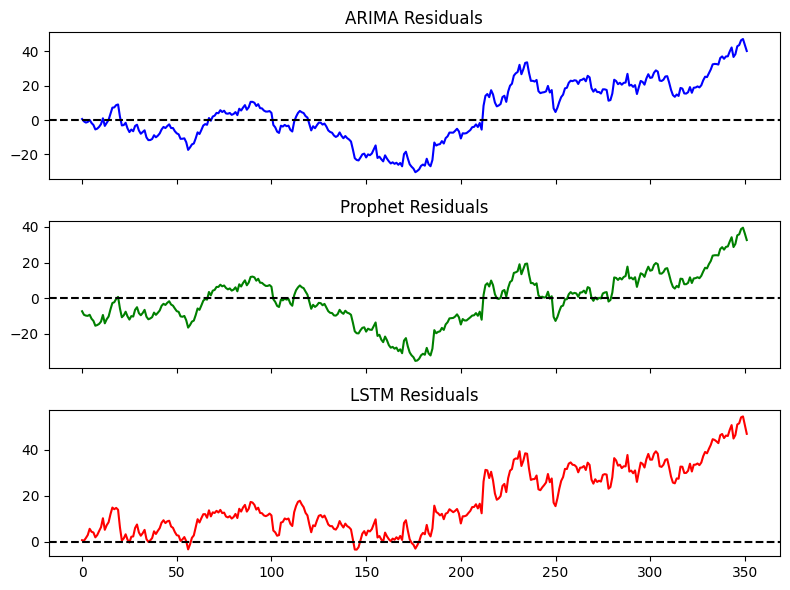

In [41]:
# Residual Plots
fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

# Residuals
arima_resid = y_test_true - arima_forecast
prophet_resid = y_test_true - prophet_forecast
lstm_resid = y_test_true[:len(lstm_pred)] - lstm_pred

axes[0].plot(test_df.index, arima_resid, color="blue")
axes[0].set_title("ARIMA Residuals")
axes[0].axhline(0, color="black", linestyle="--")

axes[1].plot(test_df.index, prophet_resid, color="green")
axes[1].set_title("Prophet Residuals")
axes[1].axhline(0, color="black", linestyle="--")

axes[2].plot(test_df.index[:len(lstm_pred)], lstm_resid, color="red")
axes[2].set_title("LSTM Residuals")
axes[2].axhline(0, color="black", linestyle="--")

plt.tight_layout()
plt.show()


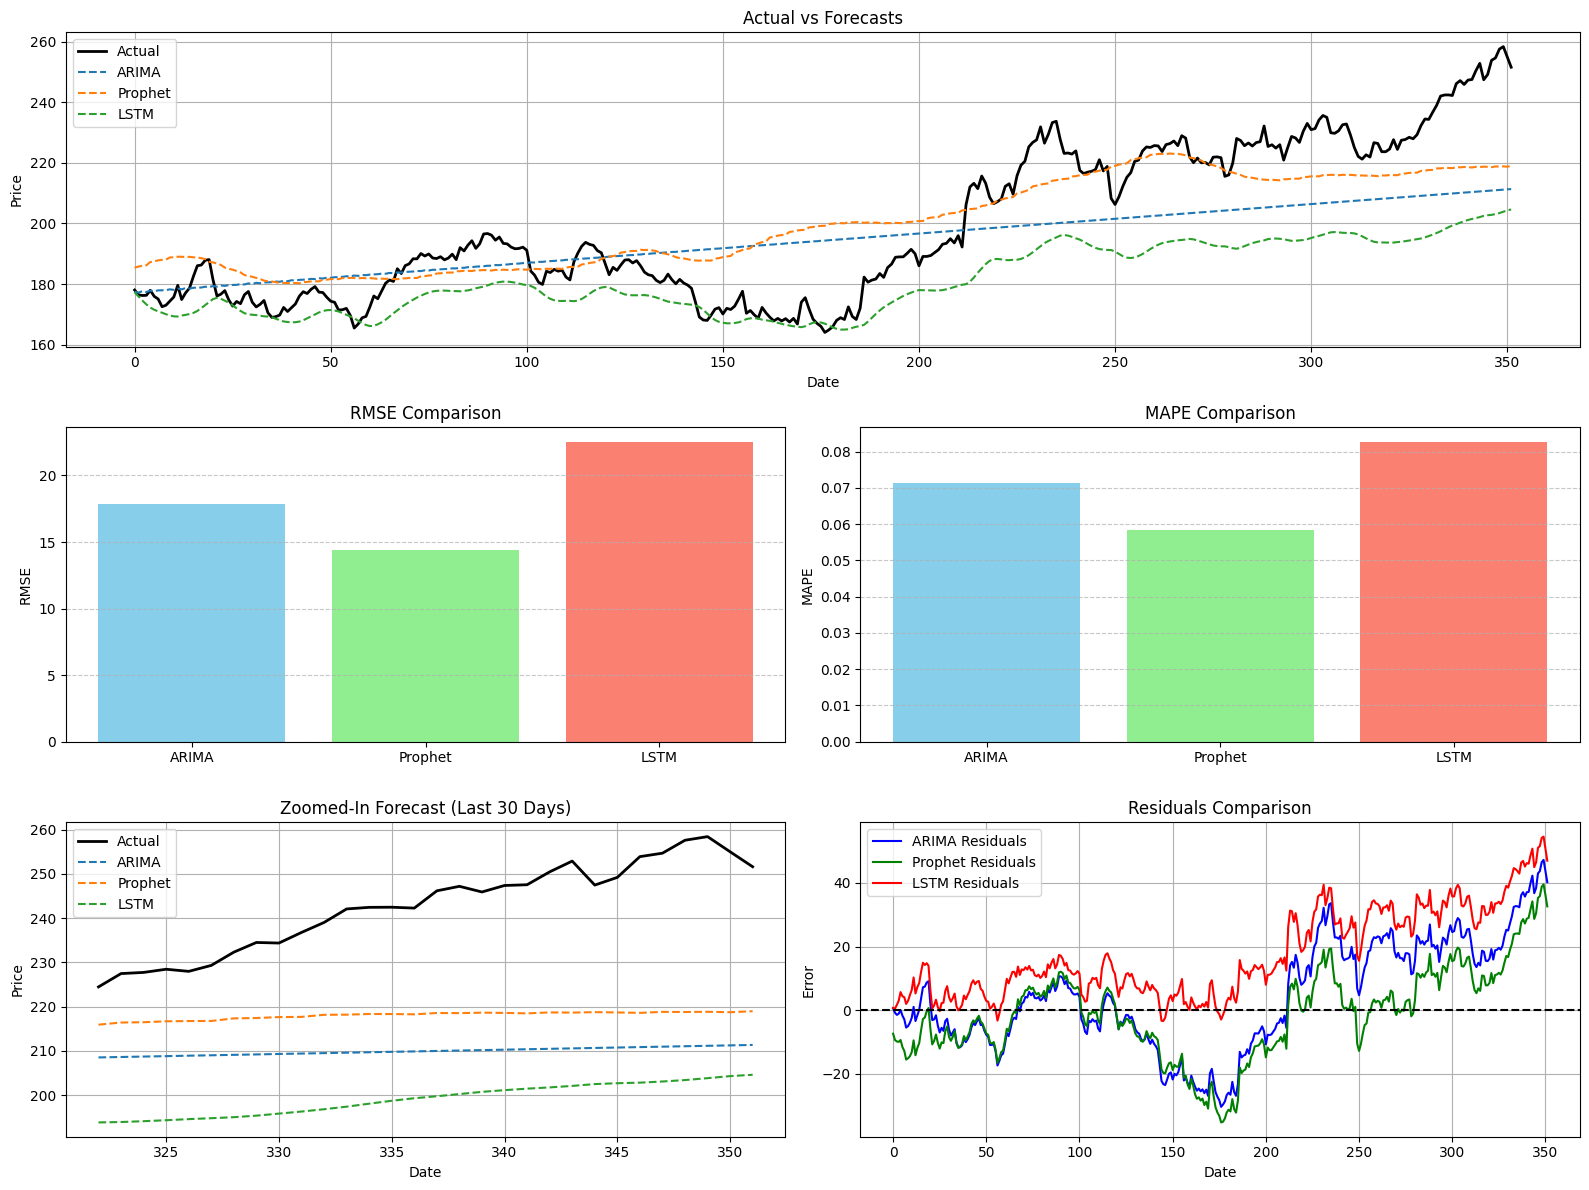

In [44]:
# Combined Dashboard for Stock Price Forecasting

fig = plt.figure(figsize=(16,12))

# 1 — Actual vs Predictions
ax1 = plt.subplot2grid((3,2), (0,0), colspan=2)
ax1.plot(test_df.index, y_test_true, label="Actual", color="black", linewidth=2)
ax1.plot(test_df.index, arima_forecast, label="ARIMA", linestyle="--")
ax1.plot(test_df.index, prophet_forecast, label="Prophet", linestyle="--")
ax1.plot(test_df.index[:len(lstm_pred)], lstm_pred, label="LSTM", linestyle="--")
ax1.set_title("Actual vs Forecasts")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.grid(True)
ax1.legend()

# 2 — RMSE Bar Chart
ax2 = plt.subplot2grid((3,2), (1,0))
ax2.bar(results_df['Model'], results_df['RMSE'], color=['skyblue','lightgreen','salmon'])
ax2.set_title("RMSE Comparison")
ax2.set_ylabel("RMSE")
ax2.grid(axis="y", linestyle="--", alpha=0.7)

# 3 — MAPE Bar Chart
ax3 = plt.subplot2grid((3,2), (1,1))
ax3.bar(results_df['Model'], results_df['MAPE'], color=['skyblue','lightgreen','salmon'])
ax3.set_title("MAPE Comparison")
ax3.set_ylabel("MAPE")
ax3.grid(axis="y", linestyle="--", alpha=0.7)

# 4 — Zoomed-In Forecast
ax4 = plt.subplot2grid((3,2), (2,0))
ax4.plot(test_df.index[-30:], y_test_true[-30:], label="Actual", color="black", linewidth=2)
ax4.plot(test_df.index[-30:], arima_forecast[-30:], label="ARIMA", linestyle="--")
ax4.plot(test_df.index[-30:], prophet_forecast[-30:], label="Prophet", linestyle="--")
ax4.plot(test_df.index[:len(lstm_pred)][-30:], lstm_pred[-30:], label="LSTM", linestyle="--")
ax4.set_title("Zoomed-In Forecast (Last 30 Days)")
ax4.set_xlabel("Date")
ax4.set_ylabel("Price")
ax4.grid(True)
ax4.legend()

# 5 — Residuals (ARIMA, Prophet, LSTM)
ax5 = plt.subplot2grid((3,2), (2,1))
ax5.plot(test_df.index, y_test_true - arima_forecast, label="ARIMA Residuals", color="blue")
ax5.plot(test_df.index, y_test_true - prophet_forecast, label="Prophet Residuals", color="green")
ax5.plot(test_df.index[:len(lstm_pred)], y_test_true[:len(lstm_pred)] - lstm_pred, label="LSTM Residuals", color="red")
ax5.axhline(0, color="black", linestyle="--")
ax5.set_title("Residuals Comparison")
ax5.set_xlabel("Date")
ax5.set_ylabel("Error")
ax5.grid(True)
ax5.legend()

plt.tight_layout()
plt.show()
